In [22]:
try:
    from eunjeon import Mecab
    import eunjeon
except:
    from konlpy.tag import Mecab
import konlpy

# numpy & pandas
import numpy as np
import pandas as pd

# scikit learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Dense, Embedding, Activation, LSTM, Bidirectional, GRU, Softmax, Dropout, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# my lib
import textlib as tl
import Word2VecModel as wv
import FastTextModel as ft

import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')

In [20]:
a = [1,2,3,4,5]
b = [11,22,33,44,55]
c = 5

all_df = []

df = pd.DataFrame()
df['e'] = ['abc'] * 5
df['a'] = np.round(a,2)
df['b'] = b
df['c'] = np.arange(0, len(a))
df['d'] = 5


df2 = pd.DataFrame()
df2['e'] = ['def'] * 5
df2['a'] = np.round(a,2)
df2['b'] = b
df2['c'] = np.arange(0, len(a))
df2['d'] = 2

all_df.append(df)
all_df.append(df2)

all_df = pd.concat(all_df)
all_df

,e,a,b,c,d
0,abc,1,11,0,5
1,abc,2,22,1,5
2,abc,3,33,2,5
3,abc,4,44,3,5
4,abc,5,55,4,5
0,def,1,11,0,2
1,def,2,22,1,2
2,def,3,33,2,2
3,def,4,44,3,2
4,def,5,55,4,2


In [23]:
w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_'
#w2v_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_'
ft_model_file_name_prefix = '../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_'
is_all_tag = False

In [24]:
# 여러개의 w2v 모델을 만들기 위한 table
MODEL_COUNT = 9
MODEL_NAMES = ['V10000_E128_W3','V10000_E128_W4','V10000_E128_W5',
               'V10000_E256_W3','V10000_E256_W4','V10000_E256_W5',
               'V10000_E384_W3','V10000_E384_W4','V10000_E384_W5']

In [25]:
# loss, accuracy plot
def plot_hist(hist):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1,2)
    loss_ax = axes[0]
    acc_ax = axes[1]

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='lower right')

    plt.show()    

In [57]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')

print( df.shape )


(65635, 6)


In [6]:
# null 인 row가 하나라도 있으면 삭제
df.dropna(axis=0, inplace=True)
print( df.shape )

(65635, 6)


In [40]:
# dataset의 문장 길이 통계
def avg(it):
    return sum(it) / len(it)

lens = [len(s) for s in df['sentence'].values]
#lens = [len(s) for s in X]

print( min(lens) )
print( max(lens) )
print( avg(lens) )

34
3222
295.5143749523882


In [59]:
# label 통계
df.groupby('label_clean').count()

,담당BA부서,date,co,sentence,label_org
label_clean,,,,,
MPAMS,333,333,333,333,333
MVNO,380,380,380,380,380
SKT eService-Tsales,98,98,98,98,98
SWING CTC,4623,4623,4623,4623,4623
SWING DBM,408,408,408,408,408
SWING NIS,385,385,385,385,385
SWING Payment,6463,6463,6463,6463,6463
SWING Portal,203,203,203,203,203
SWING SSO,403,403,403,403,403


In [60]:
# 첫 모델은 sentence와 label만 써보자
# df_zip = df[ ['sentence', 'label'] ]

y = df.pop('label_clean')
X = df.pop('sentence')

In [61]:
# 문자열로 되어 있는 label을 categorical value로 변환
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

In [62]:
# 잘 변환됐나?
print( y )
print( label_encoder.inverse_transform(y) )

[ 3 24  6 ...  6 20 32]
['SWING CTC' 'SWING 파트너관리(PRM)' 'SWING Payment' ... 'SWING Payment'
 'SWING 자원 - 계약서관리' '상품-무선']


In [63]:
w2v_model = wv.Word2VecModel()
w2v_model.load(w2v_model_file_name_prefix + MODEL_NAMES[2])
print(f'{w2v_model_file_name_prefix + MODEL_NAMES[2]} loaded')

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W5 loaded


In [64]:
# 전처리 테스트
print('--- raw sentence ---')
print( X[0] )
print()

print('--- 클렌징된 sentence ---')
cleansed_text = tl.clean_text( X[0] )
print( cleansed_text )
print()

print('--- 구두점 단위로 잘라서 배열화 ---')
tokenized_sentence = tl.segment_sentences(cleansed_text)
print( tokenized_sentence )
print()

print('--- 형태소 ---')
# SOR이니까 변경/요청 이란 단어는 항상 들어가므로 삭제
#ignore_words = ['변경','요청','SWING']
corpora = ' '.join(tl.get_corpora(sentences=tokenized_sentence,
                                  ignore_words=[],
                                  tagger=None,
                                  isAllTag=is_all_tag)).split(' ')
print(corpora)
print()

sequence = w2v_model.get_words_indexes(corpora)
print('word id')
print(sequence)
print()

print(y[0])
print(label_encoder.inverse_transform([y[0]]))


--- raw sentence ---
[Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의 . [Swing]고객상담]_상담예약 한적없으나 SMS 수신 되어 문의

010-9425-6450==970627


통합접척이력 조회> SMS/MMS 수신 2019-05-28 :15:45 
[SKT] 16시 상담예약 완료.
01094256450
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자  최 문경 : 010-4035-3522

--- 클렌징된 sentence ---
 Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의 . Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의

 


통합접척이력 조회 SMS/MMS 수신 
 SKT 시 상담예약 완료.
 
으로 전화드리겠습니다.

SMS 수신되어 확인 부탁 드립니다

해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다 

요청자 최 문경 

--- 구두점 단위로 잘라서 배열화 ---
['Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', 'Swing 고객상담 _상담예약 한적없으나 SMS 수신 되어 문의', '통합접척이력 조회 SMS/MMS 수신', 'SKT 시 상담예약 완료', '으로 전화드리겠습니다', 'SMS 수신되어 확인 부탁 드립니다', '해당 서비스 이용 고객은 따로 상담 예약 하신적이 없으나 문자 발송되었다고 하여 확인 요청 합니다', '요청자 최 문경']

--- 형태소 ---
['Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 'Swing', '고객', '상담', '_', '상담', '예약', '한', '적', '없', '으나', 'SMS', '수신', '되', '어', '문의', 

In [31]:
# raw 문장을 전처리(쪼개고 형태소로 분리하고 단어id로 바꾸고 padding까지)
def preprocess_sentence(X, w2v_model, max_sentence_len=256, ignore_words=[]):
    # 문장 전처리
    preprocessed_X = []
    print(f'{len(X)} 개의 데이터 존재 확인!')

    for i, text in enumerate(X):
        try:
            # 클렌징
            cleansed_text = tl.clean_text(text)
        except TypeError:
            print(f'      {i+1} 번째 데이터에 문제가 있어 skip!')
            continue

        # 문장으로 분리하여 배열로 리턴
        sentences = tl.segment_sentences(cleansed_text)
        # 문장 배열을 입릭으로 받아 형태소로 쪼갠 뒤, 다시 하나의 문자열로 변환하여 저장
        corpora = ' '.join(tl.get_corpora(sentences, None, True)).split(' ')
        # 단어들을 id로 변환
        sequence = w2v_model.get_words_indexes(corpora)
        
        preprocessed_X.append(sequence)

        if i % 5000 == 0 and i > 0:
            print(f'      {i} 번째 데이터 처리 완료!')

    print('데이터 전체 처리 완료!')
    # 최대 길이까지만 문장 사용. 짧은 문장은 뒤쪽에 PADDING token으로 채워서 리턴
    preprocessed_X = pad_sequences( preprocessed_X, 
                                   maxlen=max_sentence_len, 
                                   padding='post', 
                                   value=w2v_model.word2index[wv.PAD_TOKEN] )
    print('PADDING 완료!')    
    return preprocessed_X
    

In [66]:
MAX_SENTENCE_LEN = 256
preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, [])

65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!


In [67]:
# train / test 분리
X_train, X_test, y_train, y_test = \
    train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
# 배열을 numpy 로 변경
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

print( len(X_train) )
print( len(X_test) )
print( len(y_train) )
print( len(y_test) )

52508
13127
52508
13127


In [69]:
X_train.shape

(52508, 256)

In [26]:
# DL 모델. 
class SOPClassifier(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, hidden_dim,
                 batch_size, embedding_weights, train_embedding_layer, dropout, classes):
        super(SOPClassifier, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_weights])
        self.lstm = Bidirectional( LSTM(self.dec_units) )
        self.fc1 = Dense(hidden_dim, activation='relu')
        self.fc2 = Dense(hidden_dim, activation='relu')        
        self.fc3 = Dense(classes, activation='softmax')
        self.do1 = Dropout(dropout)
        self.do2 = Dropout(dropout)
        self.do3 = Dropout(dropout)
        
        self.embedding.trainable = train_embedding_layer
        
    # 단어id 벡터 -> embedding layer -> bilstm -> dropout -> (opt)attention -> fc -> droupout -> fc(softmax)

    def call(self, x):
        # (batch, seq) -> (batch, seq, embedding_dim)        
        x = self.embedding(x)

        # (batch, seq, embedding_dim) -> (batch, seq, embedding_dim*2)        
        x = self.lstm(x)
        x = self.do1(x)        

        # (batch, embedding_dim) -> (batch, 128)    
        x = self.fc1(x)
        x = self.do2(x)
        x = self.fc2(x)
        x = self.do3(x)
        x = self.fc3(x)
        
        return x


In [29]:
def train_and_evaluate(X_train, y_train, X_test, y_test, vocab_size, embedding_dim, dec_units, hidden_units, epochs, batch_size, 
       weights, train_embedding_layer, dropout, classes, model_file_name):
    model = SOPClassifier(
        vocab_size, 
        embedding_dim, 
        dec_units, 
        hidden_units,
        batch_size,
        weights,
        train_embedding_layer,
        dropout,
        classes
    )

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # early stoppiong. 3번까진 봐준다.
    es = EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=3,
                       mode='auto')

    mc = ModelCheckpoint(model_file_name, monitor='val_loss', mode='min', save_best_only=True)    
    
    history = model.fit(x=X_train, 
                        y=y_train, 
                        validation_data=(X_test, y_test),
                        epochs=epochs, 
                        batch_size=batch_size, 
                        #validation_split=0.2,
                        callbacks=[es, mc],
                        verbose=1)
    
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    plot_hist(history)
    
    return model, history, test_score

## import하고 여기만 실행하셈(word2vec)

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E128_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 39s 43ms/step - loss: 1.4456 - accuracy: 0.6121 - val_loss: 0.9141 - val_accuracy: 0.7488


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 2/20
821/821 [==============================] - 34s 42ms/step - loss: 0.9571 - accuracy: 0.7413 - val_loss: 0.7851 - val_accuracy: 0.7776


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 3/20
821/821 [==============================] - 34s 41ms/step - loss: 0.8428 - accuracy: 0.7697 - val_loss: 0.7080 - val_accuracy: 0.7931


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 4/20
821/821 [==============================] - 34s 42ms/step - loss: 0.7725 - accuracy: 0.7845 - val_loss: 0.6733 - val_accuracy: 0.8077


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 5/20
821/821 [==============================] - 34s 42ms/step - loss: 0.7215 - accuracy: 0.8003 - val_loss: 0.6374 - val_accuracy: 0.8111


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 6/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6761 - accuracy: 0.8097 - val_loss: 0.6144 - val_accuracy: 0.8210


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 7/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6419 - accuracy: 0.8187 - val_loss: 0.6069 - val_accuracy: 0.8220


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 8/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6126 - accuracy: 0.8240 - val_loss: 0.5919 - val_accuracy: 0.8239


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 9/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5851 - accuracy: 0.8337 - val_loss: 0.5905 - val_accuracy: 0.8278


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 10/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5582 - accuracy: 0.8378 - val_loss: 0.6020 - val_accuracy: 0.8258
Epoch 11/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5395 - accuracy: 0.8437 - val_loss: 0.5731 - val_accuracy: 0.8332


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 12/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5128 - accuracy: 0.8495 - val_loss: 0.5700 - val_accuracy: 0.8332


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W3\assets


Epoch 13/20
821/821 [==============================] - 34s 42ms/step - loss: 0.4949 - accuracy: 0.8537 - val_loss: 0.5834 - val_accuracy: 0.8347
Epoch 14/20
821/821 [==============================] - 35s 43ms/step - loss: 0.4720 - accuracy: 0.8601 - val_loss: 0.5818 - val_accuracy: 0.8345
Epoch 15/20
821/821 [==============================] - 35s 42ms/step - loss: 0.4540 - accuracy: 0.8647 - val_loss: 0.5997 - val_accuracy: 0.8332
411/411 - 5s - loss: 0.5997 - accuracy: 0.8332


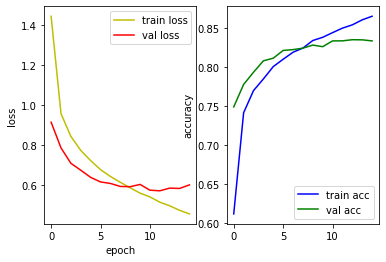

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E128_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 38s 42ms/step - loss: 1.4659 - accuracy: 0.6088 - val_loss: 0.8914 - val_accuracy: 0.7463


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 2/20
821/821 [==============================] - 34s 42ms/step - loss: 0.9641 - accuracy: 0.7400 - val_loss: 0.7763 - val_accuracy: 0.7718


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 3/20
821/821 [==============================] - 35s 42ms/step - loss: 0.8409 - accuracy: 0.7716 - val_loss: 0.7080 - val_accuracy: 0.7991


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 4/20
821/821 [==============================] - 34s 41ms/step - loss: 0.7713 - accuracy: 0.7872 - val_loss: 0.6707 - val_accuracy: 0.8034


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 5/20
821/821 [==============================] - 34s 42ms/step - loss: 0.7223 - accuracy: 0.7999 - val_loss: 0.6468 - val_accuracy: 0.8124


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 6/20
821/821 [==============================] - 35s 42ms/step - loss: 0.6834 - accuracy: 0.8081 - val_loss: 0.6349 - val_accuracy: 0.8150


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 7/20
821/821 [==============================] - 35s 42ms/step - loss: 0.6463 - accuracy: 0.8144 - val_loss: 0.6101 - val_accuracy: 0.8243


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 8/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6122 - accuracy: 0.8243 - val_loss: 0.6081 - val_accuracy: 0.8193


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 9/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5913 - accuracy: 0.8291 - val_loss: 0.5814 - val_accuracy: 0.8265


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W4\assets


Epoch 10/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5633 - accuracy: 0.8381 - val_loss: 0.5833 - val_accuracy: 0.8326
Epoch 11/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5413 - accuracy: 0.8421 - val_loss: 0.5868 - val_accuracy: 0.8241
Epoch 12/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5154 - accuracy: 0.8486 - val_loss: 0.6013 - val_accuracy: 0.8335
411/411 - 5s - loss: 0.6013 - accuracy: 0.8335


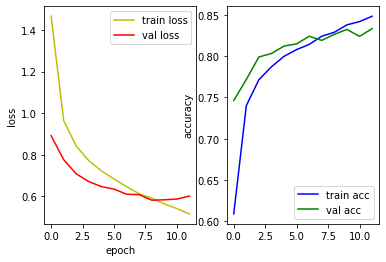

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E128_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 40s 43ms/step - loss: 1.4672 - accuracy: 0.6085 - val_loss: 0.9286 - val_accuracy: 0.7471


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 2/20
821/821 [==============================] - 35s 42ms/step - loss: 0.9744 - accuracy: 0.7371 - val_loss: 0.7655 - val_accuracy: 0.7810


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 3/20
821/821 [==============================] - 35s 42ms/step - loss: 0.8565 - accuracy: 0.7665 - val_loss: 0.7096 - val_accuracy: 0.7940


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 4/20
821/821 [==============================] - 34s 42ms/step - loss: 0.7826 - accuracy: 0.7841 - val_loss: 0.6774 - val_accuracy: 0.8016


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 5/20
821/821 [==============================] - 34s 42ms/step - loss: 0.7240 - accuracy: 0.7956 - val_loss: 0.6520 - val_accuracy: 0.8057


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 6/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6875 - accuracy: 0.8059 - val_loss: 0.6412 - val_accuracy: 0.8090


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 7/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6447 - accuracy: 0.8177 - val_loss: 0.6398 - val_accuracy: 0.8140


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 8/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6217 - accuracy: 0.8216 - val_loss: 0.5966 - val_accuracy: 0.8227


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 9/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5988 - accuracy: 0.8272 - val_loss: 0.5933 - val_accuracy: 0.8224


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 10/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5715 - accuracy: 0.8338 - val_loss: 0.5823 - val_accuracy: 0.8298


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 11/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5444 - accuracy: 0.8403 - val_loss: 0.5828 - val_accuracy: 0.8292
Epoch 12/20
821/821 [==============================] - 35s 42ms/step - loss: 0.5310 - accuracy: 0.8436 - val_loss: 0.5756 - val_accuracy: 0.8303


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E128_W5\assets


Epoch 13/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5029 - accuracy: 0.8500 - val_loss: 0.5863 - val_accuracy: 0.8310
Epoch 14/20
821/821 [==============================] - 35s 42ms/step - loss: 0.4907 - accuracy: 0.8550 - val_loss: 0.5998 - val_accuracy: 0.8322
Epoch 15/20
821/821 [==============================] - 34s 42ms/step - loss: 0.4639 - accuracy: 0.8633 - val_loss: 0.5899 - val_accuracy: 0.8324
411/411 - 5s - loss: 0.5899 - accuracy: 0.8324


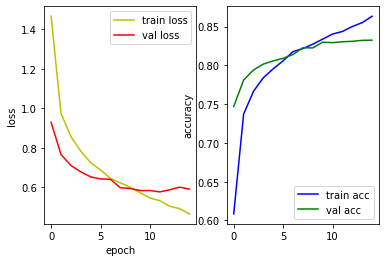

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E256_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 42s 47ms/step - loss: 1.4379 - accuracy: 0.6176 - val_loss: 0.8193 - val_accuracy: 0.7765


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9111 - accuracy: 0.7547 - val_loss: 0.7333 - val_accuracy: 0.7896


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 3/20
821/821 [==============================] - 37s 46ms/step - loss: 0.8014 - accuracy: 0.7819 - val_loss: 0.6658 - val_accuracy: 0.8059


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 4/20
821/821 [==============================] - 37s 45ms/step - loss: 0.7198 - accuracy: 0.8008 - val_loss: 0.6272 - val_accuracy: 0.8197


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 5/20
821/821 [==============================] - 38s 46ms/step - loss: 0.6628 - accuracy: 0.8158 - val_loss: 0.6131 - val_accuracy: 0.8192


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 6/20
821/821 [==============================] - 38s 46ms/step - loss: 0.6268 - accuracy: 0.8248 - val_loss: 0.6077 - val_accuracy: 0.8208


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 7/20
821/821 [==============================] - 37s 46ms/step - loss: 0.5856 - accuracy: 0.8323 - val_loss: 0.6052 - val_accuracy: 0.8252


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 8/20
821/821 [==============================] - 37s 45ms/step - loss: 0.5559 - accuracy: 0.8396 - val_loss: 0.5827 - val_accuracy: 0.8320


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W3\assets


Epoch 9/20
821/821 [==============================] - 37s 46ms/step - loss: 0.5215 - accuracy: 0.8486 - val_loss: 0.5930 - val_accuracy: 0.8309
Epoch 10/20
821/821 [==============================] - 37s 46ms/step - loss: 0.4926 - accuracy: 0.8563 - val_loss: 0.5960 - val_accuracy: 0.8340
Epoch 11/20
821/821 [==============================] - 38s 46ms/step - loss: 0.4665 - accuracy: 0.8638 - val_loss: 0.6023 - val_accuracy: 0.8360
411/411 - 5s - loss: 0.6023 - accuracy: 0.8360


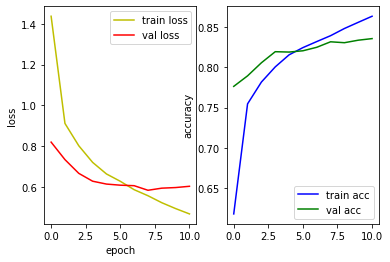

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E256_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 45s 47ms/step - loss: 1.4417 - accuracy: 0.6158 - val_loss: 0.8905 - val_accuracy: 0.7490


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9348 - accuracy: 0.7487 - val_loss: 0.7521 - val_accuracy: 0.7901


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 3/20
821/821 [==============================] - 37s 45ms/step - loss: 0.8099 - accuracy: 0.7815 - val_loss: 0.6769 - val_accuracy: 0.8042


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 4/20
821/821 [==============================] - 37s 45ms/step - loss: 0.7355 - accuracy: 0.7988 - val_loss: 0.6488 - val_accuracy: 0.8101


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 5/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6797 - accuracy: 0.8099 - val_loss: 0.6336 - val_accuracy: 0.8113


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 6/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6375 - accuracy: 0.8206 - val_loss: 0.6081 - val_accuracy: 0.8256


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 7/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6027 - accuracy: 0.8285 - val_loss: 0.5927 - val_accuracy: 0.8249


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W4\assets


Epoch 8/20
821/821 [==============================] - 37s 45ms/step - loss: 0.5663 - accuracy: 0.8370 - val_loss: 0.6159 - val_accuracy: 0.8202
Epoch 9/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5358 - accuracy: 0.8460 - val_loss: 0.6072 - val_accuracy: 0.8266
Epoch 10/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5090 - accuracy: 0.8527 - val_loss: 0.6007 - val_accuracy: 0.8318
411/411 - 5s - loss: 0.6007 - accuracy: 0.8318


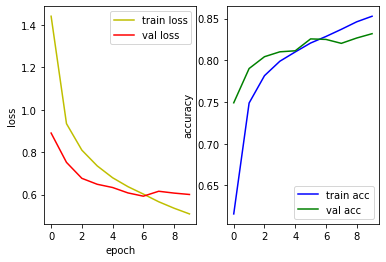

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E256_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 42s 47ms/step - loss: 1.4268 - accuracy: 0.6216 - val_loss: 0.8477 - val_accuracy: 0.7616


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9161 - accuracy: 0.7525 - val_loss: 0.7433 - val_accuracy: 0.7881


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 3/20
821/821 [==============================] - 37s 45ms/step - loss: 0.7820 - accuracy: 0.7848 - val_loss: 0.6515 - val_accuracy: 0.8102


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 4/20
821/821 [==============================] - 37s 46ms/step - loss: 0.7138 - accuracy: 0.8014 - val_loss: 0.6383 - val_accuracy: 0.8150


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 5/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6667 - accuracy: 0.8132 - val_loss: 0.6159 - val_accuracy: 0.8251


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 6/20
821/821 [==============================] - 38s 46ms/step - loss: 0.6253 - accuracy: 0.8233 - val_loss: 0.5968 - val_accuracy: 0.8286


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 7/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5850 - accuracy: 0.8339 - val_loss: 0.5941 - val_accuracy: 0.8318


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 8/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5584 - accuracy: 0.8410 - val_loss: 0.5839 - val_accuracy: 0.8324


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 9/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5257 - accuracy: 0.8472 - val_loss: 0.5809 - val_accuracy: 0.8323


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 10/20
821/821 [==============================] - 38s 46ms/step - loss: 0.4970 - accuracy: 0.8542 - val_loss: 0.5709 - val_accuracy: 0.8361


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E256_W5\assets


Epoch 11/20
821/821 [==============================] - 38s 46ms/step - loss: 0.4682 - accuracy: 0.8630 - val_loss: 0.6241 - val_accuracy: 0.8331
Epoch 12/20
821/821 [==============================] - 38s 47ms/step - loss: 0.4518 - accuracy: 0.8668 - val_loss: 0.5938 - val_accuracy: 0.8316
Epoch 13/20
821/821 [==============================] - 38s 46ms/step - loss: 0.4234 - accuracy: 0.8738 - val_loss: 0.6185 - val_accuracy: 0.8394
411/411 - 5s - loss: 0.6185 - accuracy: 0.8394


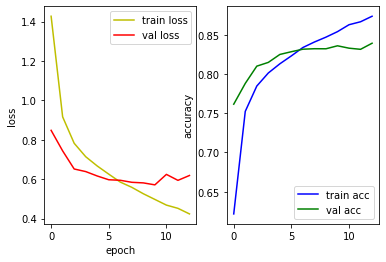

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E384_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 47s 52ms/step - loss: 1.4105 - accuracy: 0.6269 - val_loss: 0.8245 - val_accuracy: 0.7757


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 2/20
821/821 [==============================] - 41s 50ms/step - loss: 0.9073 - accuracy: 0.7570 - val_loss: 0.7004 - val_accuracy: 0.8022


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7759 - accuracy: 0.7898 - val_loss: 0.6588 - val_accuracy: 0.8121


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7001 - accuracy: 0.8088 - val_loss: 0.6510 - val_accuracy: 0.8117


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 5/20
821/821 [==============================] - 41s 50ms/step - loss: 0.6347 - accuracy: 0.8212 - val_loss: 0.6094 - val_accuracy: 0.8243


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 6/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5962 - accuracy: 0.8332 - val_loss: 0.5956 - val_accuracy: 0.8312


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 7/20
821/821 [==============================] - 41s 50ms/step - loss: 0.5597 - accuracy: 0.8435 - val_loss: 0.5847 - val_accuracy: 0.8275


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W3\assets


Epoch 8/20
821/821 [==============================] - 42s 52ms/step - loss: 0.5160 - accuracy: 0.8515 - val_loss: 0.6134 - val_accuracy: 0.8267
Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4870 - accuracy: 0.8597 - val_loss: 0.6023 - val_accuracy: 0.8343
Epoch 10/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4534 - accuracy: 0.8677 - val_loss: 0.6205 - val_accuracy: 0.8314
411/411 - 5s - loss: 0.6205 - accuracy: 0.8314


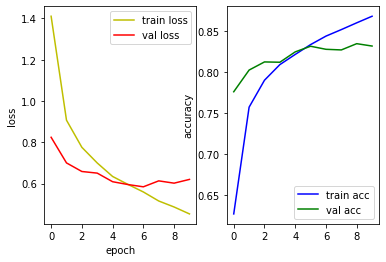

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E384_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 47s 52ms/step - loss: 1.4121 - accuracy: 0.6287 - val_loss: 0.8397 - val_accuracy: 0.7613


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 2/20
821/821 [==============================] - 42s 51ms/step - loss: 0.9130 - accuracy: 0.7565 - val_loss: 0.7231 - val_accuracy: 0.7897


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7807 - accuracy: 0.7888 - val_loss: 0.6556 - val_accuracy: 0.8102


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7067 - accuracy: 0.8047 - val_loss: 0.6192 - val_accuracy: 0.8195


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 5/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6516 - accuracy: 0.8204 - val_loss: 0.6050 - val_accuracy: 0.8252


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 6/20
821/821 [==============================] - 60s 73ms/step - loss: 0.6030 - accuracy: 0.8297 - val_loss: 0.6101 - val_accuracy: 0.8273
Epoch 7/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5646 - accuracy: 0.8383 - val_loss: 0.5956 - val_accuracy: 0.8262


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 8/20
821/821 [==============================] - 42s 52ms/step - loss: 0.5302 - accuracy: 0.8474 - val_loss: 0.6019 - val_accuracy: 0.8305
Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4977 - accuracy: 0.8554 - val_loss: 0.6129 - val_accuracy: 0.8306
Epoch 10/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4649 - accuracy: 0.8649 - val_loss: 0.5799 - val_accuracy: 0.8371


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W4\assets


Epoch 11/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4326 - accuracy: 0.8721 - val_loss: 0.6020 - val_accuracy: 0.8400
Epoch 12/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4094 - accuracy: 0.8800 - val_loss: 0.6477 - val_accuracy: 0.8355
Epoch 13/20
821/821 [==============================] - 42s 51ms/step - loss: 0.3855 - accuracy: 0.8853 - val_loss: 0.6571 - val_accuracy: 0.8328
411/411 - 5s - loss: 0.6571 - accuracy: 0.8328


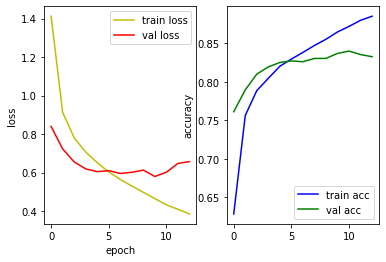

../TCL2021_Telco_Embedding_Dataset/embedding_w2v/telco_w2v_V10000_E384_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 46s 52ms/step - loss: 1.4025 - accuracy: 0.6342 - val_loss: 0.8415 - val_accuracy: 0.7669


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 2/20
821/821 [==============================] - 42s 51ms/step - loss: 0.8979 - accuracy: 0.7620 - val_loss: 0.7212 - val_accuracy: 0.7997


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7724 - accuracy: 0.7908 - val_loss: 0.6656 - val_accuracy: 0.8106


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6953 - accuracy: 0.8087 - val_loss: 0.6230 - val_accuracy: 0.8202


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 5/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6434 - accuracy: 0.8204 - val_loss: 0.6162 - val_accuracy: 0.8235


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 6/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5998 - accuracy: 0.8306 - val_loss: 0.6059 - val_accuracy: 0.8254


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 7/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5571 - accuracy: 0.8419 - val_loss: 0.6004 - val_accuracy: 0.8323


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 8/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5292 - accuracy: 0.8473 - val_loss: 0.5842 - val_accuracy: 0.8292


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4917 - accuracy: 0.8564 - val_loss: 0.5735 - val_accuracy: 0.8389


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./w2v_model_seq128\W2V_V10000_E384_W5\assets


Epoch 10/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4657 - accuracy: 0.8646 - val_loss: 0.6228 - val_accuracy: 0.8352
Epoch 11/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4360 - accuracy: 0.8722 - val_loss: 0.6234 - val_accuracy: 0.8338
Epoch 12/20
821/821 [==============================] - 42s 51ms/step - loss: 0.4138 - accuracy: 0.8780 - val_loss: 0.6081 - val_accuracy: 0.8355
411/411 - 5s - loss: 0.6081 - accuracy: 0.8355


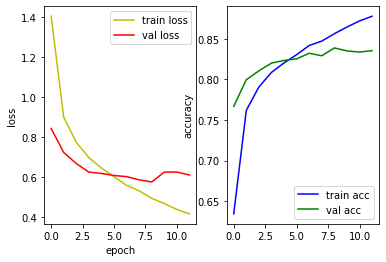

In [38]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')
    
# X, Y 추출    
y = df.pop('label_clean')
X = df.pop('sentence')    

# Y labeling
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

MAX_SENTENCE_LEN = 128

histories = dict()
test_scores = dict()

EPOCHS = 20
BATCH_SIZE = 64

all_results = []

for m in MODEL_NAMES:
    # load w2v model
    w2v_model = wv.Word2VecModel()
    model_file_name = w2v_model_file_name_prefix + m
    w2v_model.load(model_file_name)
    
    model_name = "w2v_" + m
    
    print(f'{model_file_name} loaded')
    
    # 전처리 & 벡터화
    preprocessed_X = preprocess_sentence(X, w2v_model, MAX_SENTENCE_LEN, [])
    
    # train, text 분리
    X_train, X_test, y_train, y_test = \
        train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)
    
    # np화
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test  = np.array(X_test)
    y_test  = np.array(y_test)
    
    vocab_size, embedding_dim = w2v_model.weight.shape

    model, history, test_score = \
        train_and_evaluate(X_train, y_train, X_test, y_test, vocab_size, 
                           embedding_dim,
                           256,
                           256,
                           EPOCHS,
                           BATCH_SIZE,
                           w2v_model.weight,
                           False, # embedding layer를 훈련시킬지, freezing시킬지?  True는 성능이 너무 낮다.
                           0.5, # dropout 비율
                           len(label_encoder.classes_),# class 개수
                           f'./w2v_model_seq{MAX_SENTENCE_LEN}/W2V_{m}') 

    # 모델 저장
    # model.save(f'./w2v_model/{model_name}')    
    
    # 결과 기록
    result = pd.DataFrame()
    max_epoch = len(history.history['loss'])
    min_valloss_epoch = np.argmin(history.history['val_loss'])    
    
    result['model'] = [model_name] * max_epoch

    result["train_loss"] = np.round(history.history['loss'],5)
    result["train_acc"] = np.round(history.history['accuracy'],5)
    result["val_loss"] = np.round(history.history['val_loss'],5)
    result["val_acc"] = np.round(history.history['val_accuracy'],5)
    result["epoch"] = np.arange(0, max_epoch)    
    result["min_valloss_epoch"] = [min_valloss_epoch] * max_epoch
    result["test_acc"] = [np.round(test_score[1],5)] * max_epoch
    
    all_results.append(result)

    
# 결과 파일 생성    
all_results_df = pd.concat(all_results)
all_results_df.to_csv(f'./w2v_model_seq{MAX_SENTENCE_LEN}/result_w2v.csv', index=False)

## fasttext

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 40s 43ms/step - loss: 1.3348 - accuracy: 0.6563 - val_loss: 0.8213 - val_accuracy: 0.7740


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 2/20
821/821 [==============================] - 34s 41ms/step - loss: 0.9182 - accuracy: 0.7555 - val_loss: 0.7340 - val_accuracy: 0.7904


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 3/20
821/821 [==============================] - 34s 41ms/step - loss: 0.8121 - accuracy: 0.7806 - val_loss: 0.7034 - val_accuracy: 0.7985


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 4/20
821/821 [==============================] - 34s 41ms/step - loss: 0.7432 - accuracy: 0.7964 - val_loss: 0.6606 - val_accuracy: 0.8131


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 5/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6974 - accuracy: 0.8074 - val_loss: 0.6626 - val_accuracy: 0.8118
Epoch 6/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6529 - accuracy: 0.8183 - val_loss: 0.6496 - val_accuracy: 0.8132


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 7/20
821/821 [==============================] - 34s 42ms/step - loss: 0.6216 - accuracy: 0.8278 - val_loss: 0.6475 - val_accuracy: 0.8173


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 8/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5980 - accuracy: 0.8327 - val_loss: 0.6409 - val_accuracy: 0.8212


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W3\assets


Epoch 9/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5685 - accuracy: 0.8419 - val_loss: 0.6495 - val_accuracy: 0.8211
Epoch 10/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5448 - accuracy: 0.8479 - val_loss: 0.6517 - val_accuracy: 0.8169
Epoch 11/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5290 - accuracy: 0.8504 - val_loss: 0.6457 - val_accuracy: 0.8203
411/411 - 5s - loss: 0.6457 - accuracy: 0.8203


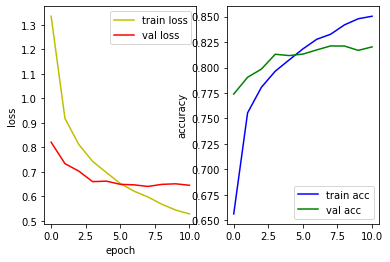

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 41s 42ms/step - loss: 1.3348 - accuracy: 0.6553 - val_loss: 0.8243 - val_accuracy: 0.7717


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 2/20
821/821 [==============================] - 34s 41ms/step - loss: 0.9087 - accuracy: 0.7575 - val_loss: 0.7225 - val_accuracy: 0.7948


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 3/20
821/821 [==============================] - 34s 41ms/step - loss: 0.8059 - accuracy: 0.7840 - val_loss: 0.6777 - val_accuracy: 0.8054


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 4/20
821/821 [==============================] - 34s 41ms/step - loss: 0.7424 - accuracy: 0.7980 - val_loss: 0.6575 - val_accuracy: 0.8123


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 5/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6978 - accuracy: 0.8107 - val_loss: 0.6526 - val_accuracy: 0.8096


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 6/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6602 - accuracy: 0.8183 - val_loss: 0.6323 - val_accuracy: 0.8176


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 7/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6179 - accuracy: 0.8279 - val_loss: 0.6317 - val_accuracy: 0.8207


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 8/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5876 - accuracy: 0.8369 - val_loss: 0.6268 - val_accuracy: 0.8217


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W4\assets


Epoch 9/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5623 - accuracy: 0.8418 - val_loss: 0.6446 - val_accuracy: 0.8185
Epoch 10/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5476 - accuracy: 0.8462 - val_loss: 0.6517 - val_accuracy: 0.8243
Epoch 11/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5255 - accuracy: 0.8530 - val_loss: 0.6393 - val_accuracy: 0.8211
411/411 - 5s - loss: 0.6393 - accuracy: 0.8211


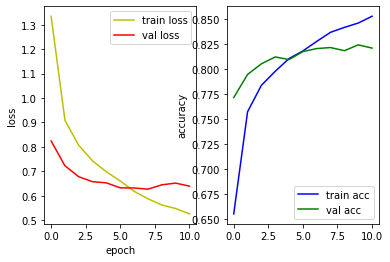

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E128_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 38s 42ms/step - loss: 1.3379 - accuracy: 0.6555 - val_loss: 0.8260 - val_accuracy: 0.7673


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 2/20
821/821 [==============================] - 34s 41ms/step - loss: 0.9177 - accuracy: 0.7554 - val_loss: 0.7340 - val_accuracy: 0.7870


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 3/20
821/821 [==============================] - 34s 41ms/step - loss: 0.8081 - accuracy: 0.7819 - val_loss: 0.6848 - val_accuracy: 0.8066


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 4/20
821/821 [==============================] - 34s 41ms/step - loss: 0.7427 - accuracy: 0.7984 - val_loss: 0.6717 - val_accuracy: 0.8074


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 5/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6994 - accuracy: 0.8081 - val_loss: 0.6623 - val_accuracy: 0.8119


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 6/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6575 - accuracy: 0.8184 - val_loss: 0.6613 - val_accuracy: 0.8095


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 7/20
821/821 [==============================] - 34s 41ms/step - loss: 0.6276 - accuracy: 0.8272 - val_loss: 0.6417 - val_accuracy: 0.8192


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 8/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5919 - accuracy: 0.8339 - val_loss: 0.6448 - val_accuracy: 0.8208
Epoch 9/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5670 - accuracy: 0.8407 - val_loss: 0.6275 - val_accuracy: 0.8194


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E128_W5\assets


Epoch 10/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5430 - accuracy: 0.8480 - val_loss: 0.6486 - val_accuracy: 0.8252
Epoch 11/20
821/821 [==============================] - 34s 41ms/step - loss: 0.5268 - accuracy: 0.8520 - val_loss: 0.6549 - val_accuracy: 0.8227
Epoch 12/20
821/821 [==============================] - 34s 42ms/step - loss: 0.5144 - accuracy: 0.8567 - val_loss: 0.6442 - val_accuracy: 0.8199
411/411 - 5s - loss: 0.6442 - accuracy: 0.8199


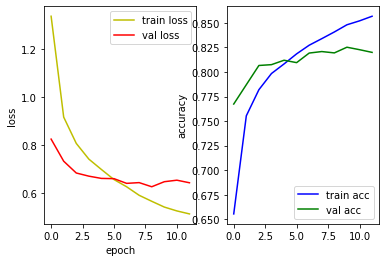

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E256_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 41s 46ms/step - loss: 1.3443 - accuracy: 0.6524 - val_loss: 0.8202 - val_accuracy: 0.7766


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9131 - accuracy: 0.7568 - val_loss: 0.7384 - val_accuracy: 0.7912


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 3/20
821/821 [==============================] - 37s 45ms/step - loss: 0.8012 - accuracy: 0.7829 - val_loss: 0.7008 - val_accuracy: 0.8038


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 4/20
821/821 [==============================] - 37s 45ms/step - loss: 0.7384 - accuracy: 0.7981 - val_loss: 0.6852 - val_accuracy: 0.8048


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 5/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6913 - accuracy: 0.8109 - val_loss: 0.6529 - val_accuracy: 0.8115


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 6/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6509 - accuracy: 0.8198 - val_loss: 0.6455 - val_accuracy: 0.8202


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W3\assets


Epoch 7/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6276 - accuracy: 0.8261 - val_loss: 0.6489 - val_accuracy: 0.8152
Epoch 8/20
821/821 [==============================] - 37s 46ms/step - loss: 0.6046 - accuracy: 0.8317 - val_loss: 0.6504 - val_accuracy: 0.8221
Epoch 9/20
821/821 [==============================] - 37s 46ms/step - loss: 0.5733 - accuracy: 0.8396 - val_loss: 0.6551 - val_accuracy: 0.8233
411/411 - 5s - loss: 0.6551 - accuracy: 0.8233


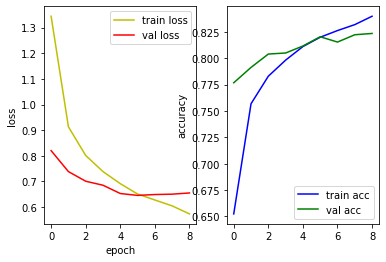

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E256_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 43s 46ms/step - loss: 1.3302 - accuracy: 0.6582 - val_loss: 0.8086 - val_accuracy: 0.7797


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9089 - accuracy: 0.7601 - val_loss: 0.7280 - val_accuracy: 0.7955


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 3/20
821/821 [==============================] - 37s 45ms/step - loss: 0.8070 - accuracy: 0.7814 - val_loss: 0.7084 - val_accuracy: 0.7968


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 4/20
821/821 [==============================] - 37s 46ms/step - loss: 0.7450 - accuracy: 0.7980 - val_loss: 0.6744 - val_accuracy: 0.8090


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 5/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6969 - accuracy: 0.8132 - val_loss: 0.6490 - val_accuracy: 0.8137


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 6/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6533 - accuracy: 0.8203 - val_loss: 0.6553 - val_accuracy: 0.8171
Epoch 7/20
821/821 [==============================] - 37s 46ms/step - loss: 0.6238 - accuracy: 0.8283 - val_loss: 0.6301 - val_accuracy: 0.8209


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W4\assets


Epoch 8/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6020 - accuracy: 0.8328 - val_loss: 0.6559 - val_accuracy: 0.8191
Epoch 9/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5836 - accuracy: 0.8396 - val_loss: 0.6460 - val_accuracy: 0.8215
Epoch 10/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5539 - accuracy: 0.8450 - val_loss: 0.6524 - val_accuracy: 0.8230
411/411 - 5s - loss: 0.6524 - accuracy: 0.8230


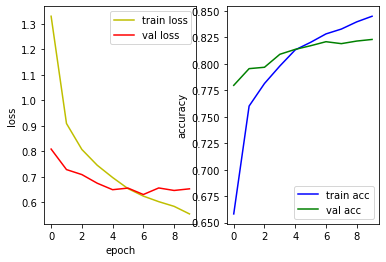

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E256_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 42s 46ms/step - loss: 1.3191 - accuracy: 0.6581 - val_loss: 0.8132 - val_accuracy: 0.7765


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 2/20
821/821 [==============================] - 37s 45ms/step - loss: 0.9026 - accuracy: 0.7597 - val_loss: 0.7084 - val_accuracy: 0.8016


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 3/20
821/821 [==============================] - 37s 45ms/step - loss: 0.7977 - accuracy: 0.7848 - val_loss: 0.6800 - val_accuracy: 0.8067


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 4/20
821/821 [==============================] - 38s 46ms/step - loss: 0.7350 - accuracy: 0.8017 - val_loss: 0.6589 - val_accuracy: 0.8128


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 5/20
821/821 [==============================] - 37s 46ms/step - loss: 0.6945 - accuracy: 0.8095 - val_loss: 0.6468 - val_accuracy: 0.8179


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 6/20
821/821 [==============================] - 37s 45ms/step - loss: 0.6471 - accuracy: 0.8228 - val_loss: 0.6459 - val_accuracy: 0.8166


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 7/20
821/821 [==============================] - 38s 46ms/step - loss: 0.6139 - accuracy: 0.8313 - val_loss: 0.6414 - val_accuracy: 0.8226


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E256_W5\assets


Epoch 8/20
821/821 [==============================] - 37s 45ms/step - loss: 0.5932 - accuracy: 0.8355 - val_loss: 0.6525 - val_accuracy: 0.8178
Epoch 9/20
821/821 [==============================] - 37s 46ms/step - loss: 0.5660 - accuracy: 0.8426 - val_loss: 0.6568 - val_accuracy: 0.8194
Epoch 10/20
821/821 [==============================] - 38s 46ms/step - loss: 0.5499 - accuracy: 0.8481 - val_loss: 0.6446 - val_accuracy: 0.8220
411/411 - 5s - loss: 0.6446 - accuracy: 0.8220


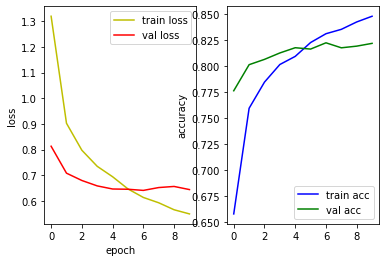

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E384_W3 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 46s 52ms/step - loss: 1.3388 - accuracy: 0.6547 - val_loss: 0.7983 - val_accuracy: 0.7816


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 2/20
821/821 [==============================] - 41s 50ms/step - loss: 0.9081 - accuracy: 0.7568 - val_loss: 0.7224 - val_accuracy: 0.7975


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.8027 - accuracy: 0.7820 - val_loss: 0.6780 - val_accuracy: 0.8071


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7407 - accuracy: 0.8001 - val_loss: 0.7098 - val_accuracy: 0.7981
Epoch 5/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6937 - accuracy: 0.8090 - val_loss: 0.6564 - val_accuracy: 0.8156


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 6/20
821/821 [==============================] - 41s 50ms/step - loss: 0.6588 - accuracy: 0.8178 - val_loss: 0.6710 - val_accuracy: 0.8118
Epoch 7/20
821/821 [==============================] - 43s 52ms/step - loss: 0.6374 - accuracy: 0.8241 - val_loss: 0.6597 - val_accuracy: 0.8194
Epoch 8/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5966 - accuracy: 0.8332 - val_loss: 0.6525 - val_accuracy: 0.8168


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5837 - accuracy: 0.8392 - val_loss: 0.6461 - val_accuracy: 0.8241


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W3\assets


Epoch 10/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5606 - accuracy: 0.8438 - val_loss: 0.6465 - val_accuracy: 0.8220
Epoch 11/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5486 - accuracy: 0.8471 - val_loss: 0.6570 - val_accuracy: 0.8208
Epoch 12/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5327 - accuracy: 0.8527 - val_loss: 0.6652 - val_accuracy: 0.8232
411/411 - 5s - loss: 0.6652 - accuracy: 0.8232


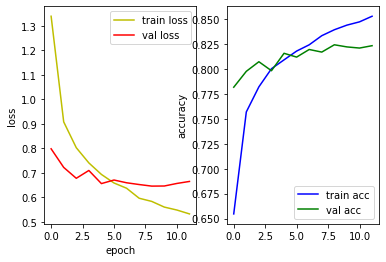

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E384_W4 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 46s 52ms/step - loss: 1.3354 - accuracy: 0.6524 - val_loss: 0.8073 - val_accuracy: 0.7756


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 2/20
821/821 [==============================] - 41s 50ms/step - loss: 0.9138 - accuracy: 0.7573 - val_loss: 0.7234 - val_accuracy: 0.7945


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.8081 - accuracy: 0.7818 - val_loss: 0.6840 - val_accuracy: 0.8076


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7402 - accuracy: 0.7992 - val_loss: 0.6652 - val_accuracy: 0.8095


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 5/20
821/821 [==============================] - 41s 51ms/step - loss: 0.7011 - accuracy: 0.8095 - val_loss: 0.6570 - val_accuracy: 0.8135


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 6/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6678 - accuracy: 0.8149 - val_loss: 0.6447 - val_accuracy: 0.8194


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 7/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6332 - accuracy: 0.8223 - val_loss: 0.6502 - val_accuracy: 0.8182
Epoch 8/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6121 - accuracy: 0.8299 - val_loss: 0.6393 - val_accuracy: 0.8191


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W4\assets


Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5895 - accuracy: 0.8360 - val_loss: 0.6481 - val_accuracy: 0.8171
Epoch 10/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5614 - accuracy: 0.8429 - val_loss: 0.6484 - val_accuracy: 0.8238
Epoch 11/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5507 - accuracy: 0.8437 - val_loss: 0.6521 - val_accuracy: 0.8249
411/411 - 5s - loss: 0.6521 - accuracy: 0.8249


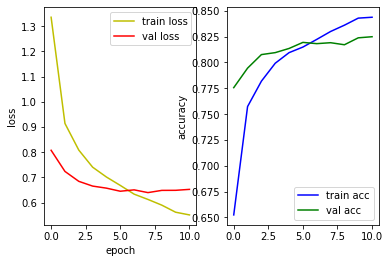

../TCL2021_Telco_Embedding_Dataset/embedding_fasttext/telco_ft_V10000_E384_W5 loaded
65635 개의 데이터 존재 확인!
      5000 번째 데이터 처리 완료!
      10000 번째 데이터 처리 완료!
      15000 번째 데이터 처리 완료!
      20000 번째 데이터 처리 완료!
      25000 번째 데이터 처리 완료!
      30000 번째 데이터 처리 완료!
      35000 번째 데이터 처리 완료!
      40000 번째 데이터 처리 완료!
      45000 번째 데이터 처리 완료!
      50000 번째 데이터 처리 완료!
      55000 번째 데이터 처리 완료!
      60000 번째 데이터 처리 완료!
      65000 번째 데이터 처리 완료!
데이터 전체 처리 완료!
PADDING 완료!
Epoch 1/20
821/821 [==============================] - 46s 51ms/step - loss: 1.3265 - accuracy: 0.6559 - val_loss: 0.8098 - val_accuracy: 0.7808


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 2/20
821/821 [==============================] - 41s 50ms/step - loss: 0.9174 - accuracy: 0.7573 - val_loss: 0.7303 - val_accuracy: 0.7959


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 3/20
821/821 [==============================] - 42s 51ms/step - loss: 0.8114 - accuracy: 0.7807 - val_loss: 0.6937 - val_accuracy: 0.8073


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 4/20
821/821 [==============================] - 42s 51ms/step - loss: 0.7451 - accuracy: 0.7990 - val_loss: 0.6775 - val_accuracy: 0.8071


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 5/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6920 - accuracy: 0.8116 - val_loss: 0.6695 - val_accuracy: 0.8141


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 6/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6604 - accuracy: 0.8187 - val_loss: 0.6514 - val_accuracy: 0.8142


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 7/20
821/821 [==============================] - 41s 50ms/step - loss: 0.6356 - accuracy: 0.8257 - val_loss: 0.6476 - val_accuracy: 0.8172


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


INFO:tensorflow:Assets written to: ./ft_model\FT_V10000_E384_W5\assets


Epoch 8/20
821/821 [==============================] - 42s 51ms/step - loss: 0.6012 - accuracy: 0.8328 - val_loss: 0.6580 - val_accuracy: 0.8213
Epoch 9/20
821/821 [==============================] - 42s 51ms/step - loss: 0.5801 - accuracy: 0.8378 - val_loss: 0.6627 - val_accuracy: 0.8170
Epoch 10/20
821/821 [==============================] - 42s 52ms/step - loss: 0.5591 - accuracy: 0.8421 - val_loss: 0.6546 - val_accuracy: 0.8212
411/411 - 5s - loss: 0.6546 - accuracy: 0.8212


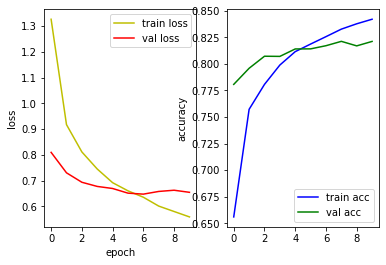

In [39]:
# sop dataset 읽어옴
input_file_name = '../TCL2021_Telco_Embedding_Dataset/dataset/sop_dataset.xlsx'
try:
    df = pd.read_excel(input_file_name, sheet_name=0, engine='openpyxl')
except FileNotFoundError:
    print(f'{input_file_name}이 없습니다! skip!')
    
# X, Y 추출    
y = df.pop('label_clean')
X = df.pop('sentence')    

# Y labeling
label_encoder = preprocessing.LabelEncoder()
y = label_encoder.fit_transform(y)

MAX_SENTENCE_LEN = 128

histories = dict()
test_scores = dict()

EPOCHS = 20
BATCH_SIZE = 64

all_results = []

for m in MODEL_NAMES:
    # load w2v model
    ft_model = ft.FastTextModel()
    model_file_name = ft_model_file_name_prefix + m
    ft_model.load(model_file_name)
    
    model_name = "ft_" + m
    
    print(f'{model_file_name} loaded')
    
    # 전처리 & 벡터화
    preprocessed_X = preprocess_sentence(X, ft_model, MAX_SENTENCE_LEN, [])
    
    # train, text 분리
    X_train, X_test, y_train, y_test = \
        train_test_split(preprocessed_X, y, test_size=0.2, random_state=42, stratify=y)
    
    # np화
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test  = np.array(X_test)
    y_test  = np.array(y_test)
    
    vocab_size, embedding_dim = ft_model.weight.shape

    model, history, test_score = \
        train_and_evaluate(X_train, y_train, X_test, y_test, vocab_size, 
                           embedding_dim,
                           256,
                           256,
                           EPOCHS,
                           BATCH_SIZE,
                           ft_model.weight,
                           False, # embedding layer를 훈련시킬지, freezing시킬지?
                           0.5, # dropout 비율
                           len(label_encoder.classes_),# class 개수
                           f'./ft_model/FT_{m}') 

    # 모델 저장
    # model.save(f'./w2v_model/{model_name}')    
    
    # 결과 기록
    result = pd.DataFrame()
    max_epoch = len(history.history['loss'])
    min_valloss_epoch = np.argmin(history.history['val_loss'])    
    
    result['model'] = [model_name] * max_epoch

    result["train_loss"] = np.round(history.history['loss'],5)
    result["train_acc"] = np.round(history.history['accuracy'],5)
    result["val_loss"] = np.round(history.history['val_loss'],5)
    result["val_acc"] = np.round(history.history['val_accuracy'],5)
    result["epoch"] = np.arange(0, max_epoch)    
    result["min_valloss_epoch"] = [min_valloss_epoch] * max_epoch
    result["test_acc"] = [np.round(test_score[1],5)] * max_epoch
    
    all_results.append(result)

    
# 결과 파일 생성    
all_results_df = pd.concat(all_results)
all_results_df.to_csv(f'./ft_model/result_ft.csv', index=False)

In [33]:
for m in MODEL_NAMES[2:]:
    model = tf.keras.models.load_model(f'./w2v_model/W2V_{m}')
    test_score = model.evaluate(X_test, y_test, verbose=2)
    
    print(test_score)
    

411/411 - 20s - loss: 0.7725 - accuracy: 0.7766
[0.7724782824516296, 0.7765673995018005]
411/411 - 18s - loss: 0.7688 - accuracy: 0.7833
[0.7687935829162598, 0.7833473086357117]
411/411 - 18s - loss: 0.7930 - accuracy: 0.7772
[0.7930063009262085, 0.7771767973899841]
411/411 - 18s - loss: 0.7916 - accuracy: 0.7788
[0.7915940284729004, 0.7787765860557556]
411/411 - 19s - loss: 0.8018 - accuracy: 0.7779
[0.8018313646316528, 0.7778624296188354]
411/411 - 20s - loss: 0.8096 - accuracy: 0.7776
[0.809615969657898, 0.7776339054107666]
411/411 - 22s - loss: 0.7731 - accuracy: 0.7853
[0.7730809450149536, 0.785251796245575]


In [23]:
#128에 4 다시 만들어서 돌려야 함

12

In [23]:
for x, e, r in zip(X_test, np.argmax(model.predict(X_test),-1), y_test):
    if e != r:
        print(' '.join([w2v_model.index2word[t] for t in x]))
        print(label_encoder.inverse_transform([e,r]))
        print('-' * 6)


OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 OSS 시설 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 확인 불가 심사 접수 취소 문의 화면 명 통합 접촉 이력 조회 서비스 번호 주소 서울 해 등 호 장애 현상 설치 장소 변경 가용 확인 미가 실사 요청 급 미 체크 접수 하나 접 수건 센터 <UNK> 수건 확인 불가 심사 접수 취소 문의 문 <UNK> 미가 심사 등록 문의 확인 티켓 종료 부탁 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

['SWING Payment' '인터페이스(SMS,MMS포함)']
------
CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 화면 명 서비스 번호 연락처 주소 장애 현상 CRM 캠페인 이번 달 약정 만료 고객 캠페인 문자 수신 것 확인 해당 고객 발신 이력 확인 문의 고객 수신 문 Swing MMS GW 전송 캠페인 번호 ABB ABB MMS GW 고객 전송 결과 확인 필요 MMS GW 부서 문 주신 대상 저희 쪽 발송 이력 확인 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 외국인 사용 확인 문의 화면 명 건물 가용 정보 조회 유선 서비스 번호 주소 서울 노원구 한글 <UNK> 길 호 장애 현상 OSS 시설 건물 가용 정보 조회 유선 화면 내 주소 사용 서비스 조회 건물 거주 외국인 사용 서비스 번호 확인 문의 외국인 서비스 번호 <UNK> 시작 서비스 번호 확인 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING 유선오더' 'SWING CTC']
------
상품 관리 선택 약정 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 선택 약정 승계 후 취소 선택 약정 입시 지원금 가입 불가 문의 SM J <UNK> 가입 당시 단말기 사용 중 확인 부탁 요청 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

['SWING 오더 - 무선오더' 'T gate']
------
빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 빌링 청구 요금 조정 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 화면 명 청구 수납 관리 서비스 번호 장애 현상 VOD 환불 월 청구 요금 원 처리 환불 금액 교시 월 청구 적용 하나 적용 문의 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['상품-단말기' 'SWING 청구']
------
긴급 청구 청구 내역 월 일 월 수납 국제 전화 요금 언제 사용 청구 문의 화면 명 서비스 번호 증상 오류 메시지 청구 수납 관리 화면 서비스 조회 시 수납 환불 내역 탭 월 수납 원 월 수납 원 확인 개회 선 해당 금액 언제 언제 사용 요금 확인 부탁 요청 차 효정 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

['SWING SSO' 'SWING Portal']
------
차 접수 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 공통 기준 정보 일 이후 결합 가능 권한 센터 부여 확인 특정 상담원 해당 업무 불가 문의 ER 동일 문 의건 결합 진행 중 처리 문의 화면 명 결합 상품 상담원 ID <UNK> B 장애 현상 해당 상담원 TB 가족 프리 가족 할인 TV 플러스 유선 일 제한 예외 권 부여 조직 소속 해당 결합 업무 진행시 서비스 가입 일 개통 가능 제한 이후 확인 문의 조직 권한 권한 적용 개별 권한 신청 지 문 문 <UNK> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



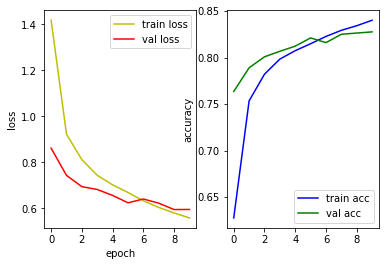

In [53]:
plot_hist(histories['True-128-False-0.5'])

In [73]:
test_scores

{'True-128-False-0.5': [0.6411054134368896, 0.820903480052948]}

# w2v
## 384-all-5 -> 83.964...
## 384-일부-5 -> 83.82...
## 128-all-5 -> 83.088...


# fasttext
## 128-all-5  -> 82.09